In [2]:
import numpy as np
import os
import glob
from python_speech_features import mfcc, logfbank, get_filterbanks, lifter
from python_speech_features.sigproc import preemphasis, framesig, powspec
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional, Dropout, Masking, TimeDistributed, Conv1D, Flatten, Reshape, BatchNormalization
from keras.optimizers import SGD
from keras import metrics
import scipy.io.wavfile as wav
import sys
import subprocess
import h5py
import matplotlib.pyplot as plt

/home/timo/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
TEST_NAMES = ['aa', 'ae', 'ah', 'aw', 'ay', 'b', 'ch', 'd', 'dh', 'dx', 'eh', 'er', 'ey',
              'f', 'g', 'hh', 'ih', 'iy', 'jh', 'k', 'l', 'm', 'n', 'ng', 'ow', 'oy', 'p',
              'r', 's', 'sh', 'sil', 't', 'th', 'uh', 'uw', 'v', 'w', 'y', 'z']

FOLDINGS = {
    "ux": "uw",
    "axr": "er",
    "axh": "ah",
    "ax-h": "ah",
    "ax": "ah",
    "em": "m",
    "nx": "n",
    "en": "n",
    "eng": "ng",
    "hv": "hh",
    "el": "l",
    "zh": "sh",
    "ao": "aa",
    "ix": "ih",
    "pcl": "sil",
    "tcl": "sil",
    "kcl": "sil",
    "qcl": "sil",
    "bcl": "sil",
    "dcl": "sil",
    "gcl": "sil",
    "h#": "sil",
    "#h": "sil",
    "pau": "sil",
    "epi": "sil"
}

In [34]:
def phn_file_to_labels(fname, winstep=0.01, rate=16000.0):
    # Load PHN file
    phn_text = np.loadtxt(fname,
                          dtype={'names': ('start', 'end', 'phone'),
                                 'formats': (np.int32, np.int32, 'S4')},
                          comments=None)

    # Length of annotations in num samples
    _, phn_len, _ = phn_text[-1]
    labels = []
    for i, (start, end, phn) in enumerate(phn_text):
        # Round the start & end times to the window start
        start = int(start / (rate * winstep))
        end = int(end / (rate * winstep))
        labels.extend([phn.decode("utf-8")] * (end - start))

    return np.asarray(labels)


def fold_label(phn):
    if phn in FOLDINGS:
        return FOLDINGS[phn]
    else:
        return phn


def label_to_int(phn):
    return TEST_NAMES.index(phn)


def to_one_hot(labels, num_classes=48):
    """Convert class labels from scalars to one-hot vectors."""
    num_labels = labels.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[index_offset + labels.ravel()] = 1
    return labels_one_hot

In [127]:
source_dir = '../../TIMIT/TIMIT/TRAIN'
target_dir = '../../TIMIT/0_frames/TRAIN'

drs = sorted(glob.glob(os.path.join(source_dir, 'DR*')))
cmd = "sox {0} -t wav {1}"

#target_file_X = h5py.File(os.path.join(target_dir, 'features_framed.h5'), "w")
#target_file_Y = h5py.File(os.path.join(target_dir, 'features_preemph.h5'), "w")

winlen = 0.025
winstep = 0.01

#fft_in = []
fft_out = []
#log_energy_out = []
log_fbanks_out = []

for dialect_region_dir in drs:
    print(dialect_region_dir)
    dr = os.path.split(dialect_region_dir)[-1]
    for speaker_dir in sorted(glob.glob(os.path.join(dialect_region_dir, "*"))):
        speaker = os.path.split(speaker_dir)[-1]
        print(speaker_dir)
        for audio_file in sorted(glob.glob(os.path.join(speaker_dir, "*.WAV"))):
            fname = os.path.splitext(os.path.split(audio_file)[-1])[0]
            if fname[8:10] == "SA":
                continue
            print(audio_file)
            file_target_dir = os.path.join(target_dir, dr, speaker)
            if not os.path.exists(file_target_dir):
                os.makedirs(file_target_dir)

            # Convert NIST wav files using sox
            converted_target_file = os.path.join(file_target_dir, os.path.split(audio_file)[-1])
            if not os.path.isfile(converted_target_file):
                subprocess.call(cmd.format(audio_file, converted_target_file), shell=True)

            (rate, sig) = wav.read(converted_target_file)
            #print(sig.shape)
            
            # Convert to overlapping frames
            x = framesig(sig, winlen * rate, winstep * rate)
            
            # Pre-emphasis
            sig_preemph = preemphasis(sig)
            
            # Convert to overlapping frames
            y = framesig(sig_preemph, winlen * rate, winstep * rate)
            
            #for frame in y:
            #    fft_in.append(frame)
            
            # Do fft
            y = powspec(y, 512)
            
            for frame in y:
                fft_out.append(frame)
                
            #energy = np.sum(y,1) # this stores the total energy in each frame
            #log_energy = np.log(np.where(energy == 0, np.finfo(float).eps,energy)) # if energy is zero, we get problems with log
            
            #for frame in log_energy:
            #    log_energy_out.append(frame)
            
            fbanks = get_filterbanks(20, 512, rate, 0, None)
            # Comput logfbanks
            y = np.dot(y, fbanks.T)
            y = np.log(np.where(y == 0,np.finfo(float).eps,y))
            
            for frame in y:
                log_fbanks_out.append(frame)
            
            #group = target_file_X.create_group(fname)
            #group.create_dataset('features', data=x)
            #group2 = target_file_Y.create_group(fname)
            #group2.create_dataset('features', data=y)

../../TIMIT/TIMIT/TRAIN/DR1
../../TIMIT/TIMIT/TRAIN/DR1/FCJF0
../../TIMIT/TIMIT/TRAIN/DR1/FCJF0/DR1FCJF0SI1027.WAV
../../TIMIT/TIMIT/TRAIN/DR1/FCJF0/DR1FCJF0SI1657.WAV
../../TIMIT/TIMIT/TRAIN/DR1/FCJF0/DR1FCJF0SI648.WAV
../../TIMIT/TIMIT/TRAIN/DR1/FCJF0/DR1FCJF0SX127.WAV
../../TIMIT/TIMIT/TRAIN/DR1/FCJF0/DR1FCJF0SX217.WAV
../../TIMIT/TIMIT/TRAIN/DR1/FCJF0/DR1FCJF0SX307.WAV
../../TIMIT/TIMIT/TRAIN/DR1/FCJF0/DR1FCJF0SX37.WAV
../../TIMIT/TIMIT/TRAIN/DR1/FCJF0/DR1FCJF0SX397.WAV
../../TIMIT/TIMIT/TRAIN/DR1/FDAW0
../../TIMIT/TIMIT/TRAIN/DR1/FDAW0/DR1FDAW0SI1271.WAV
../../TIMIT/TIMIT/TRAIN/DR1/FDAW0/DR1FDAW0SI1406.WAV
../../TIMIT/TIMIT/TRAIN/DR1/FDAW0/DR1FDAW0SI2036.WAV
../../TIMIT/TIMIT/TRAIN/DR1/FDAW0/DR1FDAW0SX146.WAV
../../TIMIT/TIMIT/TRAIN/DR1/FDAW0/DR1FDAW0SX236.WAV
../../TIMIT/TIMIT/TRAIN/DR1/FDAW0/DR1FDAW0SX326.WAV
../../TIMIT/TIMIT/TRAIN/DR1/FDAW0/DR1FDAW0SX416.WAV
../../TIMIT/TIMIT/TRAIN/DR1/FDAW0/DR1FDAW0SX56.WAV
../../TIMIT/TIMIT/TRAIN/DR1/FDML0
../../TIMIT/TIMIT/TRAIN/DR1/FDML0/D

../../TIMIT/TIMIT/TRAIN/DR1/MJWT0/DR1MJWT0SX211.WAV
../../TIMIT/TIMIT/TRAIN/DR1/MJWT0/DR1MJWT0SX301.WAV
../../TIMIT/TIMIT/TRAIN/DR1/MJWT0/DR1MJWT0SX31.WAV
../../TIMIT/TIMIT/TRAIN/DR1/MJWT0/DR1MJWT0SX391.WAV
../../TIMIT/TIMIT/TRAIN/DR1/MKLS0
../../TIMIT/TIMIT/TRAIN/DR1/MKLS0/DR1MKLS0SI1437.WAV
../../TIMIT/TIMIT/TRAIN/DR1/MKLS0/DR1MKLS0SI1533.WAV
../../TIMIT/TIMIT/TRAIN/DR1/MKLS0/DR1MKLS0SI2067.WAV
../../TIMIT/TIMIT/TRAIN/DR1/MKLS0/DR1MKLS0SX177.WAV
../../TIMIT/TIMIT/TRAIN/DR1/MKLS0/DR1MKLS0SX267.WAV
../../TIMIT/TIMIT/TRAIN/DR1/MKLS0/DR1MKLS0SX357.WAV
../../TIMIT/TIMIT/TRAIN/DR1/MKLS0/DR1MKLS0SX447.WAV
../../TIMIT/TIMIT/TRAIN/DR1/MKLS0/DR1MKLS0SX87.WAV
../../TIMIT/TIMIT/TRAIN/DR1/MKLW0
../../TIMIT/TIMIT/TRAIN/DR1/MKLW0/DR1MKLW0SI1571.WAV
../../TIMIT/TIMIT/TRAIN/DR1/MKLW0/DR1MKLW0SI1844.WAV
../../TIMIT/TIMIT/TRAIN/DR1/MKLW0/DR1MKLW0SI2201.WAV
../../TIMIT/TIMIT/TRAIN/DR1/MKLW0/DR1MKLW0SX131.WAV
../../TIMIT/TIMIT/TRAIN/DR1/MKLW0/DR1MKLW0SX221.WAV
../../TIMIT/TIMIT/TRAIN/DR1/MKLW0/DR1MKLW0SX

../../TIMIT/TIMIT/TRAIN/DR2/FCYL0/DR2FCYL0SX217.WAV
../../TIMIT/TIMIT/TRAIN/DR2/FCYL0/DR2FCYL0SX349.WAV
../../TIMIT/TIMIT/TRAIN/DR2/FCYL0/DR2FCYL0SX37.WAV
../../TIMIT/TIMIT/TRAIN/DR2/FCYL0/DR2FCYL0SX397.WAV
../../TIMIT/TIMIT/TRAIN/DR2/FDAS1
../../TIMIT/TIMIT/TRAIN/DR2/FDAS1/DR2FDAS1SI1461.WAV
../../TIMIT/TIMIT/TRAIN/DR2/FDAS1/DR2FDAS1SI2091.WAV
../../TIMIT/TIMIT/TRAIN/DR2/FDAS1/DR2FDAS1SI831.WAV
../../TIMIT/TIMIT/TRAIN/DR2/FDAS1/DR2FDAS1SX111.WAV
../../TIMIT/TIMIT/TRAIN/DR2/FDAS1/DR2FDAS1SX201.WAV
../../TIMIT/TIMIT/TRAIN/DR2/FDAS1/DR2FDAS1SX21.WAV
../../TIMIT/TIMIT/TRAIN/DR2/FDAS1/DR2FDAS1SX291.WAV
../../TIMIT/TIMIT/TRAIN/DR2/FDAS1/DR2FDAS1SX381.WAV
../../TIMIT/TIMIT/TRAIN/DR2/FDNC0
../../TIMIT/TIMIT/TRAIN/DR2/FDNC0/DR2FDNC0SI1278.WAV
../../TIMIT/TIMIT/TRAIN/DR2/FDNC0/DR2FDNC0SI1908.WAV
../../TIMIT/TIMIT/TRAIN/DR2/FDNC0/DR2FDNC0SI2287.WAV
../../TIMIT/TIMIT/TRAIN/DR2/FDNC0/DR2FDNC0SX108.WAV
../../TIMIT/TIMIT/TRAIN/DR2/FDNC0/DR2FDNC0SX18.WAV
../../TIMIT/TIMIT/TRAIN/DR2/FDNC0/DR2FDNC0SX19

../../TIMIT/TIMIT/TRAIN/DR2/MCEW0/DR2MCEW0SX452.WAV
../../TIMIT/TIMIT/TRAIN/DR2/MCEW0/DR2MCEW0SX92.WAV
../../TIMIT/TIMIT/TRAIN/DR2/MCTM0
../../TIMIT/TIMIT/TRAIN/DR2/MCTM0/DR2MCTM0SI1350.WAV
../../TIMIT/TIMIT/TRAIN/DR2/MCTM0/DR2MCTM0SI1980.WAV
../../TIMIT/TIMIT/TRAIN/DR2/MCTM0/DR2MCTM0SI720.WAV
../../TIMIT/TIMIT/TRAIN/DR2/MCTM0/DR2MCTM0SX180.WAV
../../TIMIT/TIMIT/TRAIN/DR2/MCTM0/DR2MCTM0SX270.WAV
../../TIMIT/TIMIT/TRAIN/DR2/MCTM0/DR2MCTM0SX360.WAV
../../TIMIT/TIMIT/TRAIN/DR2/MCTM0/DR2MCTM0SX450.WAV
../../TIMIT/TIMIT/TRAIN/DR2/MCTM0/DR2MCTM0SX90.WAV
../../TIMIT/TIMIT/TRAIN/DR2/MDBP0
../../TIMIT/TIMIT/TRAIN/DR2/MDBP0/DR2MDBP0SI1158.WAV
../../TIMIT/TIMIT/TRAIN/DR2/MDBP0/DR2MDBP0SI1788.WAV
../../TIMIT/TIMIT/TRAIN/DR2/MDBP0/DR2MDBP0SI528.WAV
../../TIMIT/TIMIT/TRAIN/DR2/MDBP0/DR2MDBP0SX168.WAV
../../TIMIT/TIMIT/TRAIN/DR2/MDBP0/DR2MDBP0SX258.WAV
../../TIMIT/TIMIT/TRAIN/DR2/MDBP0/DR2MDBP0SX348.WAV
../../TIMIT/TIMIT/TRAIN/DR2/MDBP0/DR2MDBP0SX438.WAV
../../TIMIT/TIMIT/TRAIN/DR2/MDBP0/DR2MDBP0SX78

../../TIMIT/TIMIT/TRAIN/DR2/MKAJ0/DR2MKAJ0SX424.WAV
../../TIMIT/TIMIT/TRAIN/DR2/MKAJ0/DR2MKAJ0SX64.WAV
../../TIMIT/TIMIT/TRAIN/DR2/MKDT0
../../TIMIT/TIMIT/TRAIN/DR2/MKDT0/DR2MKDT0SI2153.WAV
../../TIMIT/TIMIT/TRAIN/DR2/MKDT0/DR2MKDT0SI814.WAV
../../TIMIT/TIMIT/TRAIN/DR2/MKDT0/DR2MKDT0SI893.WAV
../../TIMIT/TIMIT/TRAIN/DR2/MKDT0/DR2MKDT0SX173.WAV
../../TIMIT/TIMIT/TRAIN/DR2/MKDT0/DR2MKDT0SX263.WAV
../../TIMIT/TIMIT/TRAIN/DR2/MKDT0/DR2MKDT0SX353.WAV
../../TIMIT/TIMIT/TRAIN/DR2/MKDT0/DR2MKDT0SX443.WAV
../../TIMIT/TIMIT/TRAIN/DR2/MKDT0/DR2MKDT0SX83.WAV
../../TIMIT/TIMIT/TRAIN/DR2/MKJO0
../../TIMIT/TIMIT/TRAIN/DR2/MKJO0/DR2MKJO0SI1517.WAV
../../TIMIT/TIMIT/TRAIN/DR2/MKJO0/DR2MKJO0SI2147.WAV
../../TIMIT/TIMIT/TRAIN/DR2/MKJO0/DR2MKJO0SI887.WAV
../../TIMIT/TIMIT/TRAIN/DR2/MKJO0/DR2MKJO0SX167.WAV
../../TIMIT/TIMIT/TRAIN/DR2/MKJO0/DR2MKJO0SX257.WAV
../../TIMIT/TIMIT/TRAIN/DR2/MKJO0/DR2MKJO0SX424.WAV
../../TIMIT/TIMIT/TRAIN/DR2/MKJO0/DR2MKJO0SX437.WAV
../../TIMIT/TIMIT/TRAIN/DR2/MKJO0/DR2MKJO0SX77.

../../TIMIT/TIMIT/TRAIN/DR2/MSAT0/DR2MSAT0SX86.WAV
../../TIMIT/TIMIT/TRAIN/DR2/MTAT1
../../TIMIT/TIMIT/TRAIN/DR2/MTAT1/DR2MTAT1SI1409.WAV
../../TIMIT/TIMIT/TRAIN/DR2/MTAT1/DR2MTAT1SI1627.WAV
../../TIMIT/TIMIT/TRAIN/DR2/MTAT1/DR2MTAT1SI779.WAV
../../TIMIT/TIMIT/TRAIN/DR2/MTAT1/DR2MTAT1SX149.WAV
../../TIMIT/TIMIT/TRAIN/DR2/MTAT1/DR2MTAT1SX239.WAV
../../TIMIT/TIMIT/TRAIN/DR2/MTAT1/DR2MTAT1SX329.WAV
../../TIMIT/TIMIT/TRAIN/DR2/MTAT1/DR2MTAT1SX419.WAV
../../TIMIT/TIMIT/TRAIN/DR2/MTAT1/DR2MTAT1SX59.WAV
../../TIMIT/TIMIT/TRAIN/DR2/MTBC0
../../TIMIT/TIMIT/TRAIN/DR2/MTBC0/DR2MTBC0SI1173.WAV
../../TIMIT/TIMIT/TRAIN/DR2/MTBC0/DR2MTBC0SI1803.WAV
../../TIMIT/TIMIT/TRAIN/DR2/MTBC0/DR2MTBC0SI543.WAV
../../TIMIT/TIMIT/TRAIN/DR2/MTBC0/DR2MTBC0SX183.WAV
../../TIMIT/TIMIT/TRAIN/DR2/MTBC0/DR2MTBC0SX273.WAV
../../TIMIT/TIMIT/TRAIN/DR2/MTBC0/DR2MTBC0SX347.WAV
../../TIMIT/TIMIT/TRAIN/DR2/MTBC0/DR2MTBC0SX363.WAV
../../TIMIT/TIMIT/TRAIN/DR2/MTBC0/DR2MTBC0SX93.WAV
../../TIMIT/TIMIT/TRAIN/DR2/MTDB0
../../TIMIT/T

../../TIMIT/TIMIT/TRAIN/DR3/FPAZ0/DR3FPAZ0SX423.WAV
../../TIMIT/TIMIT/TRAIN/DR3/FPAZ0/DR3FPAZ0SX63.WAV
../../TIMIT/TIMIT/TRAIN/DR3/FSJS0
../../TIMIT/TIMIT/TRAIN/DR3/FSJS0/DR3FSJS0SI1171.WAV
../../TIMIT/TIMIT/TRAIN/DR3/FSJS0/DR3FSJS0SI1801.WAV
../../TIMIT/TIMIT/TRAIN/DR3/FSJS0/DR3FSJS0SI541.WAV
../../TIMIT/TIMIT/TRAIN/DR3/FSJS0/DR3FSJS0SX181.WAV
../../TIMIT/TIMIT/TRAIN/DR3/FSJS0/DR3FSJS0SX271.WAV
../../TIMIT/TIMIT/TRAIN/DR3/FSJS0/DR3FSJS0SX361.WAV
../../TIMIT/TIMIT/TRAIN/DR3/FSJS0/DR3FSJS0SX451.WAV
../../TIMIT/TIMIT/TRAIN/DR3/FSJS0/DR3FSJS0SX91.WAV
../../TIMIT/TIMIT/TRAIN/DR3/FSJW0
../../TIMIT/TIMIT/TRAIN/DR3/FSJW0/DR3FSJW0SI1333.WAV
../../TIMIT/TIMIT/TRAIN/DR3/FSJW0/DR3FSJW0SI1963.WAV
../../TIMIT/TIMIT/TRAIN/DR3/FSJW0/DR3FSJW0SI703.WAV
../../TIMIT/TIMIT/TRAIN/DR3/FSJW0/DR3FSJW0SX163.WAV
../../TIMIT/TIMIT/TRAIN/DR3/FSJW0/DR3FSJW0SX253.WAV
../../TIMIT/TIMIT/TRAIN/DR3/FSJW0/DR3FSJW0SX343.WAV
../../TIMIT/TIMIT/TRAIN/DR3/FSJW0/DR3FSJW0SX433.WAV
../../TIMIT/TIMIT/TRAIN/DR3/FSJW0/DR3FSJW0SX73

../../TIMIT/TIMIT/TRAIN/DR3/MDSS1/DR3MDSS1SX67.WAV
../../TIMIT/TIMIT/TRAIN/DR3/MDTB0
../../TIMIT/TIMIT/TRAIN/DR3/MDTB0/DR3MDTB0SI1200.WAV
../../TIMIT/TIMIT/TRAIN/DR3/MDTB0/DR3MDTB0SI1830.WAV
../../TIMIT/TIMIT/TRAIN/DR3/MDTB0/DR3MDTB0SI570.WAV
../../TIMIT/TIMIT/TRAIN/DR3/MDTB0/DR3MDTB0SX120.WAV
../../TIMIT/TIMIT/TRAIN/DR3/MDTB0/DR3MDTB0SX210.WAV
../../TIMIT/TIMIT/TRAIN/DR3/MDTB0/DR3MDTB0SX300.WAV
../../TIMIT/TIMIT/TRAIN/DR3/MDTB0/DR3MDTB0SX321.WAV
../../TIMIT/TIMIT/TRAIN/DR3/MDTB0/DR3MDTB0SX390.WAV
../../TIMIT/TIMIT/TRAIN/DR3/MDWM0
../../TIMIT/TIMIT/TRAIN/DR3/MDWM0/DR3MDWM0SI1546.WAV
../../TIMIT/TIMIT/TRAIN/DR3/MDWM0/DR3MDWM0SI2176.WAV
../../TIMIT/TIMIT/TRAIN/DR3/MDWM0/DR3MDWM0SI916.WAV
../../TIMIT/TIMIT/TRAIN/DR3/MDWM0/DR3MDWM0SX106.WAV
../../TIMIT/TIMIT/TRAIN/DR3/MDWM0/DR3MDWM0SX16.WAV
../../TIMIT/TIMIT/TRAIN/DR3/MDWM0/DR3MDWM0SX286.WAV
../../TIMIT/TIMIT/TRAIN/DR3/MDWM0/DR3MDWM0SX376.WAV
../../TIMIT/TIMIT/TRAIN/DR3/MDWM0/DR3MDWM0SX433.WAV
../../TIMIT/TIMIT/TRAIN/DR3/MFMC0
../../TIMIT/

../../TIMIT/TIMIT/TRAIN/DR3/MRBC0/DR3MRBC0SX419.WAV
../../TIMIT/TIMIT/TRAIN/DR3/MRBC0/DR3MRBC0SX59.WAV
../../TIMIT/TIMIT/TRAIN/DR3/MRDS0
../../TIMIT/TIMIT/TRAIN/DR3/MRDS0/DR3MRDS0SI1167.WAV
../../TIMIT/TIMIT/TRAIN/DR3/MRDS0/DR3MRDS0SI1797.WAV
../../TIMIT/TIMIT/TRAIN/DR3/MRDS0/DR3MRDS0SI537.WAV
../../TIMIT/TIMIT/TRAIN/DR3/MRDS0/DR3MRDS0SX177.WAV
../../TIMIT/TIMIT/TRAIN/DR3/MRDS0/DR3MRDS0SX267.WAV
../../TIMIT/TIMIT/TRAIN/DR3/MRDS0/DR3MRDS0SX357.WAV
../../TIMIT/TIMIT/TRAIN/DR3/MRDS0/DR3MRDS0SX447.WAV
../../TIMIT/TIMIT/TRAIN/DR3/MRDS0/DR3MRDS0SX87.WAV
../../TIMIT/TIMIT/TRAIN/DR3/MREE0
../../TIMIT/TIMIT/TRAIN/DR3/MREE0/DR3MREE0SI1104.WAV
../../TIMIT/TIMIT/TRAIN/DR3/MREE0/DR3MREE0SI1734.WAV
../../TIMIT/TIMIT/TRAIN/DR3/MREE0/DR3MREE0SI1959.WAV
../../TIMIT/TIMIT/TRAIN/DR3/MREE0/DR3MREE0SX114.WAV
../../TIMIT/TIMIT/TRAIN/DR3/MREE0/DR3MREE0SX204.WAV
../../TIMIT/TIMIT/TRAIN/DR3/MREE0/DR3MREE0SX24.WAV
../../TIMIT/TIMIT/TRAIN/DR3/MREE0/DR3MREE0SX294.WAV
../../TIMIT/TIMIT/TRAIN/DR3/MREE0/DR3MREE0SX38

../../TIMIT/TIMIT/TRAIN/DR4/FDKN0/DR4FDKN0SX271.WAV
../../TIMIT/TIMIT/TRAIN/DR4/FDKN0/DR4FDKN0SX361.WAV
../../TIMIT/TIMIT/TRAIN/DR4/FDKN0/DR4FDKN0SX451.WAV
../../TIMIT/TIMIT/TRAIN/DR4/FDKN0/DR4FDKN0SX91.WAV
../../TIMIT/TIMIT/TRAIN/DR4/FEEH0
../../TIMIT/TIMIT/TRAIN/DR4/FEEH0/DR4FEEH0SI1112.WAV
../../TIMIT/TIMIT/TRAIN/DR4/FEEH0/DR4FEEH0SI1742.WAV
../../TIMIT/TIMIT/TRAIN/DR4/FEEH0/DR4FEEH0SI471.WAV
../../TIMIT/TIMIT/TRAIN/DR4/FEEH0/DR4FEEH0SX122.WAV
../../TIMIT/TIMIT/TRAIN/DR4/FEEH0/DR4FEEH0SX212.WAV
../../TIMIT/TIMIT/TRAIN/DR4/FEEH0/DR4FEEH0SX302.WAV
../../TIMIT/TIMIT/TRAIN/DR4/FEEH0/DR4FEEH0SX32.WAV
../../TIMIT/TIMIT/TRAIN/DR4/FEEH0/DR4FEEH0SX392.WAV
../../TIMIT/TIMIT/TRAIN/DR4/FJWB1
../../TIMIT/TIMIT/TRAIN/DR4/FJWB1/DR4FJWB1SI2055.WAV
../../TIMIT/TIMIT/TRAIN/DR4/FJWB1/DR4FJWB1SI748.WAV
../../TIMIT/TIMIT/TRAIN/DR4/FJWB1/DR4FJWB1SI795.WAV
../../TIMIT/TIMIT/TRAIN/DR4/FJWB1/DR4FJWB1SX165.WAV
../../TIMIT/TIMIT/TRAIN/DR4/FJWB1/DR4FJWB1SX255.WAV
../../TIMIT/TIMIT/TRAIN/DR4/FJWB1/DR4FJWB1SX345

../../TIMIT/TIMIT/TRAIN/DR4/MFWK0/DR4MFWK0SX439.WAV
../../TIMIT/TIMIT/TRAIN/DR4/MFWK0/DR4MFWK0SX79.WAV
../../TIMIT/TIMIT/TRAIN/DR4/MGAG0
../../TIMIT/TIMIT/TRAIN/DR4/MGAG0/DR4MGAG0SI1321.WAV
../../TIMIT/TIMIT/TRAIN/DR4/MGAG0/DR4MGAG0SI645.WAV
../../TIMIT/TIMIT/TRAIN/DR4/MGAG0/DR4MGAG0SI691.WAV
../../TIMIT/TIMIT/TRAIN/DR4/MGAG0/DR4MGAG0SX151.WAV
../../TIMIT/TIMIT/TRAIN/DR4/MGAG0/DR4MGAG0SX241.WAV
../../TIMIT/TIMIT/TRAIN/DR4/MGAG0/DR4MGAG0SX331.WAV
../../TIMIT/TIMIT/TRAIN/DR4/MGAG0/DR4MGAG0SX421.WAV
../../TIMIT/TIMIT/TRAIN/DR4/MGAG0/DR4MGAG0SX61.WAV
../../TIMIT/TIMIT/TRAIN/DR4/MGJC0
../../TIMIT/TIMIT/TRAIN/DR4/MGJC0/DR4MGJC0SI1256.WAV
../../TIMIT/TIMIT/TRAIN/DR4/MGJC0/DR4MGJC0SI1335.WAV
../../TIMIT/TIMIT/TRAIN/DR4/MGJC0/DR4MGJC0SI1965.WAV
../../TIMIT/TIMIT/TRAIN/DR4/MGJC0/DR4MGJC0SX165.WAV
../../TIMIT/TIMIT/TRAIN/DR4/MGJC0/DR4MGJC0SX255.WAV
../../TIMIT/TIMIT/TRAIN/DR4/MGJC0/DR4MGJC0SX345.WAV
../../TIMIT/TIMIT/TRAIN/DR4/MGJC0/DR4MGJC0SX435.WAV
../../TIMIT/TIMIT/TRAIN/DR4/MGJC0/DR4MGJC0SX75

../../TIMIT/TIMIT/TRAIN/DR4/MLJH0/DR4MLJH0SX244.WAV
../../TIMIT/TIMIT/TRAIN/DR4/MLJH0/DR4MLJH0SX334.WAV
../../TIMIT/TIMIT/TRAIN/DR4/MLJH0/DR4MLJH0SX424.WAV
../../TIMIT/TIMIT/TRAIN/DR4/MLJH0/DR4MLJH0SX64.WAV
../../TIMIT/TIMIT/TRAIN/DR4/MLSH0
../../TIMIT/TIMIT/TRAIN/DR4/MLSH0/DR4MLSH0SI1417.WAV
../../TIMIT/TIMIT/TRAIN/DR4/MLSH0/DR4MLSH0SI2047.WAV
../../TIMIT/TIMIT/TRAIN/DR4/MLSH0/DR4MLSH0SI787.WAV
../../TIMIT/TIMIT/TRAIN/DR4/MLSH0/DR4MLSH0SX157.WAV
../../TIMIT/TIMIT/TRAIN/DR4/MLSH0/DR4MLSH0SX247.WAV
../../TIMIT/TIMIT/TRAIN/DR4/MLSH0/DR4MLSH0SX337.WAV
../../TIMIT/TIMIT/TRAIN/DR4/MLSH0/DR4MLSH0SX427.WAV
../../TIMIT/TIMIT/TRAIN/DR4/MLSH0/DR4MLSH0SX67.WAV
../../TIMIT/TIMIT/TRAIN/DR4/MMBS0
../../TIMIT/TIMIT/TRAIN/DR4/MMBS0/DR4MMBS0SI1151.WAV
../../TIMIT/TIMIT/TRAIN/DR4/MMBS0/DR4MMBS0SI1781.WAV
../../TIMIT/TIMIT/TRAIN/DR4/MMBS0/DR4MMBS0SI521.WAV
../../TIMIT/TIMIT/TRAIN/DR4/MMBS0/DR4MMBS0SX161.WAV
../../TIMIT/TIMIT/TRAIN/DR4/MMBS0/DR4MMBS0SX251.WAV
../../TIMIT/TIMIT/TRAIN/DR4/MMBS0/DR4MMBS0SX34

../../TIMIT/TIMIT/TRAIN/DR4/MTRT0/DR4MTRT0SI597.WAV
../../TIMIT/TIMIT/TRAIN/DR4/MTRT0/DR4MTRT0SX147.WAV
../../TIMIT/TIMIT/TRAIN/DR4/MTRT0/DR4MTRT0SX237.WAV
../../TIMIT/TIMIT/TRAIN/DR4/MTRT0/DR4MTRT0SX254.WAV
../../TIMIT/TIMIT/TRAIN/DR4/MTRT0/DR4MTRT0SX417.WAV
../../TIMIT/TIMIT/TRAIN/DR4/MTRT0/DR4MTRT0SX57.WAV
../../TIMIT/TIMIT/TRAIN/DR5
../../TIMIT/TIMIT/TRAIN/DR5/FBJL0
../../TIMIT/TIMIT/TRAIN/DR5/FBJL0/DR5FBJL0SI1552.WAV
../../TIMIT/TIMIT/TRAIN/DR5/FBJL0/DR5FBJL0SI2182.WAV
../../TIMIT/TIMIT/TRAIN/DR5/FBJL0/DR5FBJL0SI922.WAV
../../TIMIT/TIMIT/TRAIN/DR5/FBJL0/DR5FBJL0SX112.WAV
../../TIMIT/TIMIT/TRAIN/DR5/FBJL0/DR5FBJL0SX202.WAV
../../TIMIT/TIMIT/TRAIN/DR5/FBJL0/DR5FBJL0SX22.WAV
../../TIMIT/TIMIT/TRAIN/DR5/FBJL0/DR5FBJL0SX292.WAV
../../TIMIT/TIMIT/TRAIN/DR5/FBJL0/DR5FBJL0SX382.WAV
../../TIMIT/TIMIT/TRAIN/DR5/FBMH0
../../TIMIT/TIMIT/TRAIN/DR5/FBMH0/DR5FBMH0SI1136.WAV
../../TIMIT/TIMIT/TRAIN/DR5/FBMH0/DR5FBMH0SI1766.WAV
../../TIMIT/TIMIT/TRAIN/DR5/FBMH0/DR5FBMH0SI970.WAV
../../TIMIT/TIMIT/

../../TIMIT/TIMIT/TRAIN/DR5/FSJG0/DR5FSJG0SX130.WAV
../../TIMIT/TIMIT/TRAIN/DR5/FSJG0/DR5FSJG0SX220.WAV
../../TIMIT/TIMIT/TRAIN/DR5/FSJG0/DR5FSJG0SX310.WAV
../../TIMIT/TIMIT/TRAIN/DR5/FSJG0/DR5FSJG0SX40.WAV
../../TIMIT/TIMIT/TRAIN/DR5/FSJG0/DR5FSJG0SX400.WAV
../../TIMIT/TIMIT/TRAIN/DR5/FSKP0
../../TIMIT/TIMIT/TRAIN/DR5/FSKP0/DR5FSKP0SI1098.WAV
../../TIMIT/TIMIT/TRAIN/DR5/FSKP0/DR5FSKP0SI1728.WAV
../../TIMIT/TIMIT/TRAIN/DR5/FSKP0/DR5FSKP0SI468.WAV
../../TIMIT/TIMIT/TRAIN/DR5/FSKP0/DR5FSKP0SX108.WAV
../../TIMIT/TIMIT/TRAIN/DR5/FSKP0/DR5FSKP0SX18.WAV
../../TIMIT/TIMIT/TRAIN/DR5/FSKP0/DR5FSKP0SX198.WAV
../../TIMIT/TIMIT/TRAIN/DR5/FSKP0/DR5FSKP0SX288.WAV
../../TIMIT/TIMIT/TRAIN/DR5/FSKP0/DR5FSKP0SX378.WAV
../../TIMIT/TIMIT/TRAIN/DR5/FSMM0
../../TIMIT/TIMIT/TRAIN/DR5/FSMM0/DR5FSMM0SI1314.WAV
../../TIMIT/TIMIT/TRAIN/DR5/FSMM0/DR5FSMM0SI1944.WAV
../../TIMIT/TIMIT/TRAIN/DR5/FSMM0/DR5FSMM0SI684.WAV
../../TIMIT/TIMIT/TRAIN/DR5/FSMM0/DR5FSMM0SX144.WAV
../../TIMIT/TIMIT/TRAIN/DR5/FSMM0/DR5FSMM0SX23

../../TIMIT/TIMIT/TRAIN/DR5/MJPG0/DR5MJPG0SI561.WAV
../../TIMIT/TIMIT/TRAIN/DR5/MJPG0/DR5MJPG0SX111.WAV
../../TIMIT/TIMIT/TRAIN/DR5/MJPG0/DR5MJPG0SX201.WAV
../../TIMIT/TIMIT/TRAIN/DR5/MJPG0/DR5MJPG0SX21.WAV
../../TIMIT/TIMIT/TRAIN/DR5/MJPG0/DR5MJPG0SX291.WAV
../../TIMIT/TIMIT/TRAIN/DR5/MJPG0/DR5MJPG0SX381.WAV
../../TIMIT/TIMIT/TRAIN/DR5/MJRG0
../../TIMIT/TIMIT/TRAIN/DR5/MJRG0/DR5MJRG0SI1366.WAV
../../TIMIT/TIMIT/TRAIN/DR5/MJRG0/DR5MJRG0SI1996.WAV
../../TIMIT/TIMIT/TRAIN/DR5/MJRG0/DR5MJRG0SI736.WAV
../../TIMIT/TIMIT/TRAIN/DR5/MJRG0/DR5MJRG0SX106.WAV
../../TIMIT/TIMIT/TRAIN/DR5/MJRG0/DR5MJRG0SX16.WAV
../../TIMIT/TIMIT/TRAIN/DR5/MJRG0/DR5MJRG0SX286.WAV
../../TIMIT/TIMIT/TRAIN/DR5/MJRG0/DR5MJRG0SX352.WAV
../../TIMIT/TIMIT/TRAIN/DR5/MJRG0/DR5MJRG0SX376.WAV
../../TIMIT/TIMIT/TRAIN/DR5/MJWG0
../../TIMIT/TIMIT/TRAIN/DR5/MJWG0/DR5MJWG0SI2155.WAV
../../TIMIT/TIMIT/TRAIN/DR5/MJWG0/DR5MJWG0SI813.WAV
../../TIMIT/TIMIT/TRAIN/DR5/MJWG0/DR5MJWG0SI895.WAV
../../TIMIT/TIMIT/TRAIN/DR5/MJWG0/DR5MJWG0SX175

../../TIMIT/TIMIT/TRAIN/DR5/MSRR0/DR5MSRR0SX141.WAV
../../TIMIT/TIMIT/TRAIN/DR5/MSRR0/DR5MSRR0SX231.WAV
../../TIMIT/TIMIT/TRAIN/DR5/MSRR0/DR5MSRR0SX30.WAV
../../TIMIT/TIMIT/TRAIN/DR5/MSRR0/DR5MSRR0SX411.WAV
../../TIMIT/TIMIT/TRAIN/DR5/MSRR0/DR5MSRR0SX51.WAV
../../TIMIT/TIMIT/TRAIN/DR5/MTAT0
../../TIMIT/TIMIT/TRAIN/DR5/MTAT0/DR5MTAT0SI1110.WAV
../../TIMIT/TIMIT/TRAIN/DR5/MTAT0/DR5MTAT0SI1740.WAV
../../TIMIT/TIMIT/TRAIN/DR5/MTAT0/DR5MTAT0SI811.WAV
../../TIMIT/TIMIT/TRAIN/DR5/MTAT0/DR5MTAT0SX120.WAV
../../TIMIT/TIMIT/TRAIN/DR5/MTAT0/DR5MTAT0SX210.WAV
../../TIMIT/TIMIT/TRAIN/DR5/MTAT0/DR5MTAT0SX30.WAV
../../TIMIT/TIMIT/TRAIN/DR5/MTAT0/DR5MTAT0SX300.WAV
../../TIMIT/TIMIT/TRAIN/DR5/MTAT0/DR5MTAT0SX390.WAV
../../TIMIT/TIMIT/TRAIN/DR5/MTDP0
../../TIMIT/TIMIT/TRAIN/DR5/MTDP0/DR5MTDP0SI1274.WAV
../../TIMIT/TIMIT/TRAIN/DR5/MTDP0/DR5MTDP0SI1521.WAV
../../TIMIT/TIMIT/TRAIN/DR5/MTDP0/DR5MTDP0SI2151.WAV
../../TIMIT/TIMIT/TRAIN/DR5/MTDP0/DR5MTDP0SX171.WAV
../../TIMIT/TIMIT/TRAIN/DR5/MTDP0/DR5MTDP0SX26

../../TIMIT/TIMIT/TRAIN/DR6/FTAJ0/DR6FTAJ0SI474.WAV
../../TIMIT/TIMIT/TRAIN/DR6/FTAJ0/DR6FTAJ0SI699.WAV
../../TIMIT/TIMIT/TRAIN/DR6/FTAJ0/DR6FTAJ0SX159.WAV
../../TIMIT/TIMIT/TRAIN/DR6/FTAJ0/DR6FTAJ0SX249.WAV
../../TIMIT/TIMIT/TRAIN/DR6/FTAJ0/DR6FTAJ0SX339.WAV
../../TIMIT/TIMIT/TRAIN/DR6/FTAJ0/DR6FTAJ0SX429.WAV
../../TIMIT/TIMIT/TRAIN/DR6/FTAJ0/DR6FTAJ0SX69.WAV
../../TIMIT/TIMIT/TRAIN/DR6/MABC0
../../TIMIT/TIMIT/TRAIN/DR6/MABC0/DR6MABC0SI1620.WAV
../../TIMIT/TIMIT/TRAIN/DR6/MABC0/DR6MABC0SI2041.WAV
../../TIMIT/TIMIT/TRAIN/DR6/MABC0/DR6MABC0SI781.WAV
../../TIMIT/TIMIT/TRAIN/DR6/MABC0/DR6MABC0SX151.WAV
../../TIMIT/TIMIT/TRAIN/DR6/MABC0/DR6MABC0SX241.WAV
../../TIMIT/TIMIT/TRAIN/DR6/MABC0/DR6MABC0SX331.WAV
../../TIMIT/TIMIT/TRAIN/DR6/MABC0/DR6MABC0SX421.WAV
../../TIMIT/TIMIT/TRAIN/DR6/MABC0/DR6MABC0SX61.WAV
../../TIMIT/TIMIT/TRAIN/DR6/MAJP0
../../TIMIT/TIMIT/TRAIN/DR6/MAJP0/DR6MAJP0SI1074.WAV
../../TIMIT/TIMIT/TRAIN/DR6/MAJP0/DR6MAJP0SI1704.WAV
../../TIMIT/TIMIT/TRAIN/DR6/MAJP0/DR6MAJP0SI23

../../TIMIT/TIMIT/TRAIN/DR6/MSVS0/DR6MSVS0SX38.WAV
../../TIMIT/TIMIT/TRAIN/DR6/MSVS0/DR6MSVS0SX398.WAV
../../TIMIT/TIMIT/TRAIN/DR6/MTJU0
../../TIMIT/TIMIT/TRAIN/DR6/MTJU0/DR6MTJU0SI2020.WAV
../../TIMIT/TIMIT/TRAIN/DR6/MTJU0/DR6MTJU0SI2269.WAV
../../TIMIT/TIMIT/TRAIN/DR6/MTJU0/DR6MTJU0SI760.WAV
../../TIMIT/TIMIT/TRAIN/DR6/MTJU0/DR6MTJU0SX130.WAV
../../TIMIT/TIMIT/TRAIN/DR6/MTJU0/DR6MTJU0SX220.WAV
../../TIMIT/TIMIT/TRAIN/DR6/MTJU0/DR6MTJU0SX310.WAV
../../TIMIT/TIMIT/TRAIN/DR6/MTJU0/DR6MTJU0SX40.WAV
../../TIMIT/TIMIT/TRAIN/DR6/MTJU0/DR6MTJU0SX400.WAV
../../TIMIT/TIMIT/TRAIN/DR6/MTXS0
../../TIMIT/TIMIT/TRAIN/DR6/MTXS0/DR6MTXS0SI1060.WAV
../../TIMIT/TIMIT/TRAIN/DR6/MTXS0/DR6MTXS0SI1690.WAV
../../TIMIT/TIMIT/TRAIN/DR6/MTXS0/DR6MTXS0SI2320.WAV
../../TIMIT/TIMIT/TRAIN/DR6/MTXS0/DR6MTXS0SX160.WAV
../../TIMIT/TIMIT/TRAIN/DR6/MTXS0/DR6MTXS0SX250.WAV
../../TIMIT/TIMIT/TRAIN/DR6/MTXS0/DR6MTXS0SX340.WAV
../../TIMIT/TIMIT/TRAIN/DR6/MTXS0/DR6MTXS0SX430.WAV
../../TIMIT/TIMIT/TRAIN/DR6/MTXS0/DR6MTXS0SX7

../../TIMIT/TIMIT/TRAIN/DR7/MADD0/DR7MADD0SX448.WAV
../../TIMIT/TIMIT/TRAIN/DR7/MADD0/DR7MADD0SX88.WAV
../../TIMIT/TIMIT/TRAIN/DR7/MAEO0
../../TIMIT/TIMIT/TRAIN/DR7/MAEO0/DR7MAEO0SI1326.WAV
../../TIMIT/TIMIT/TRAIN/DR7/MAEO0/DR7MAEO0SI1655.WAV
../../TIMIT/TIMIT/TRAIN/DR7/MAEO0/DR7MAEO0SI1956.WAV
../../TIMIT/TIMIT/TRAIN/DR7/MAEO0/DR7MAEO0SX156.WAV
../../TIMIT/TIMIT/TRAIN/DR7/MAEO0/DR7MAEO0SX246.WAV
../../TIMIT/TIMIT/TRAIN/DR7/MAEO0/DR7MAEO0SX336.WAV
../../TIMIT/TIMIT/TRAIN/DR7/MAEO0/DR7MAEO0SX426.WAV
../../TIMIT/TIMIT/TRAIN/DR7/MAEO0/DR7MAEO0SX66.WAV
../../TIMIT/TIMIT/TRAIN/DR7/MAFM0
../../TIMIT/TIMIT/TRAIN/DR7/MAFM0/DR7MAFM0SI1569.WAV
../../TIMIT/TIMIT/TRAIN/DR7/MAFM0/DR7MAFM0SI2199.WAV
../../TIMIT/TIMIT/TRAIN/DR7/MAFM0/DR7MAFM0SI939.WAV
../../TIMIT/TIMIT/TRAIN/DR7/MAFM0/DR7MAFM0SX129.WAV
../../TIMIT/TIMIT/TRAIN/DR7/MAFM0/DR7MAFM0SX219.WAV
../../TIMIT/TIMIT/TRAIN/DR7/MAFM0/DR7MAFM0SX309.WAV
../../TIMIT/TIMIT/TRAIN/DR7/MAFM0/DR7MAFM0SX39.WAV
../../TIMIT/TIMIT/TRAIN/DR7/MAFM0/DR7MAFM0SX39

../../TIMIT/TIMIT/TRAIN/DR7/MFXS0
../../TIMIT/TIMIT/TRAIN/DR7/MFXS0/DR7MFXS0SI1674.WAV
../../TIMIT/TIMIT/TRAIN/DR7/MFXS0/DR7MFXS0SI2225.WAV
../../TIMIT/TIMIT/TRAIN/DR7/MFXS0/DR7MFXS0SI2304.WAV
../../TIMIT/TIMIT/TRAIN/DR7/MFXS0/DR7MFXS0SX144.WAV
../../TIMIT/TIMIT/TRAIN/DR7/MFXS0/DR7MFXS0SX234.WAV
../../TIMIT/TIMIT/TRAIN/DR7/MFXS0/DR7MFXS0SX324.WAV
../../TIMIT/TIMIT/TRAIN/DR7/MFXS0/DR7MFXS0SX414.WAV
../../TIMIT/TIMIT/TRAIN/DR7/MFXS0/DR7MFXS0SX54.WAV
../../TIMIT/TIMIT/TRAIN/DR7/MFXV0
../../TIMIT/TIMIT/TRAIN/DR7/MFXV0/DR7MFXV0SI1005.WAV
../../TIMIT/TIMIT/TRAIN/DR7/MFXV0/DR7MFXV0SI1342.WAV
../../TIMIT/TIMIT/TRAIN/DR7/MFXV0/DR7MFXV0SI1635.WAV
../../TIMIT/TIMIT/TRAIN/DR7/MFXV0/DR7MFXV0SX105.WAV
../../TIMIT/TIMIT/TRAIN/DR7/MFXV0/DR7MFXV0SX15.WAV
../../TIMIT/TIMIT/TRAIN/DR7/MFXV0/DR7MFXV0SX195.WAV
../../TIMIT/TIMIT/TRAIN/DR7/MFXV0/DR7MFXV0SX285.WAV
../../TIMIT/TIMIT/TRAIN/DR7/MFXV0/DR7MFXV0SX375.WAV
../../TIMIT/TIMIT/TRAIN/DR7/MGAK0
../../TIMIT/TIMIT/TRAIN/DR7/MGAK0/DR7MGAK0SI1036.WAV
../../TIM

../../TIMIT/TIMIT/TRAIN/DR7/MRLJ1/DR7MRLJ1SI2332.WAV
../../TIMIT/TIMIT/TRAIN/DR7/MRLJ1/DR7MRLJ1SX141.WAV
../../TIMIT/TIMIT/TRAIN/DR7/MRLJ1/DR7MRLJ1SX231.WAV
../../TIMIT/TIMIT/TRAIN/DR7/MRLJ1/DR7MRLJ1SX321.WAV
../../TIMIT/TIMIT/TRAIN/DR7/MRLJ1/DR7MRLJ1SX411.WAV
../../TIMIT/TIMIT/TRAIN/DR7/MRLJ1/DR7MRLJ1SX51.WAV
../../TIMIT/TIMIT/TRAIN/DR7/MRMG0
../../TIMIT/TIMIT/TRAIN/DR7/MRMG0/DR7MRMG0SI1080.WAV
../../TIMIT/TIMIT/TRAIN/DR7/MRMG0/DR7MRMG0SI1710.WAV
../../TIMIT/TIMIT/TRAIN/DR7/MRMG0/DR7MRMG0SI2340.WAV
../../TIMIT/TIMIT/TRAIN/DR7/MRMG0/DR7MRMG0SX180.WAV
../../TIMIT/TIMIT/TRAIN/DR7/MRMG0/DR7MRMG0SX270.WAV
../../TIMIT/TIMIT/TRAIN/DR7/MRMG0/DR7MRMG0SX360.WAV
../../TIMIT/TIMIT/TRAIN/DR7/MRMG0/DR7MRMG0SX450.WAV
../../TIMIT/TIMIT/TRAIN/DR7/MRMG0/DR7MRMG0SX90.WAV
../../TIMIT/TIMIT/TRAIN/DR7/MRMH0
../../TIMIT/TIMIT/TRAIN/DR7/MRMH0/DR7MRMH0SI1021.WAV
../../TIMIT/TIMIT/TRAIN/DR7/MRMH0/DR7MRMH0SI1349.WAV
../../TIMIT/TIMIT/TRAIN/DR7/MRMH0/DR7MRMH0SI2281.WAV
../../TIMIT/TIMIT/TRAIN/DR7/MRMH0/DR7MRMH0S

../../TIMIT/TIMIT/TRAIN/DR8/FBCG1/DR8FBCG1SX172.WAV
../../TIMIT/TIMIT/TRAIN/DR8/FBCG1/DR8FBCG1SX262.WAV
../../TIMIT/TIMIT/TRAIN/DR8/FBCG1/DR8FBCG1SX352.WAV
../../TIMIT/TIMIT/TRAIN/DR8/FBCG1/DR8FBCG1SX442.WAV
../../TIMIT/TIMIT/TRAIN/DR8/FBCG1/DR8FBCG1SX82.WAV
../../TIMIT/TIMIT/TRAIN/DR8/FCEG0
../../TIMIT/TIMIT/TRAIN/DR8/FCEG0/DR8FCEG0SI1248.WAV
../../TIMIT/TIMIT/TRAIN/DR8/FCEG0/DR8FCEG0SI1878.WAV
../../TIMIT/TIMIT/TRAIN/DR8/FCEG0/DR8FCEG0SI618.WAV
../../TIMIT/TIMIT/TRAIN/DR8/FCEG0/DR8FCEG0SX168.WAV
../../TIMIT/TIMIT/TRAIN/DR8/FCEG0/DR8FCEG0SX258.WAV
../../TIMIT/TIMIT/TRAIN/DR8/FCEG0/DR8FCEG0SX348.WAV
../../TIMIT/TIMIT/TRAIN/DR8/FCEG0/DR8FCEG0SX438.WAV
../../TIMIT/TIMIT/TRAIN/DR8/FCEG0/DR8FCEG0SX78.WAV
../../TIMIT/TIMIT/TRAIN/DR8/FCLT0
../../TIMIT/TIMIT/TRAIN/DR8/FCLT0/DR8FCLT0SI1438.WAV
../../TIMIT/TIMIT/TRAIN/DR8/FCLT0/DR8FCLT0SI2068.WAV
../../TIMIT/TIMIT/TRAIN/DR8/FCLT0/DR8FCLT0SI808.WAV
../../TIMIT/TIMIT/TRAIN/DR8/FCLT0/DR8FCLT0SX178.WAV
../../TIMIT/TIMIT/TRAIN/DR8/FCLT0/DR8FCLT0SX26

../../TIMIT/TIMIT/TRAIN/DR8/MRDM0/DR8MRDM0SX335.WAV
../../TIMIT/TIMIT/TRAIN/DR8/MRDM0/DR8MRDM0SX425.WAV
../../TIMIT/TIMIT/TRAIN/DR8/MRDM0/DR8MRDM0SX65.WAV
../../TIMIT/TIMIT/TRAIN/DR8/MRLK0
../../TIMIT/TIMIT/TRAIN/DR8/MRLK0/DR8MRLK0SI1468.WAV
../../TIMIT/TIMIT/TRAIN/DR8/MRLK0/DR8MRLK0SI2140.WAV
../../TIMIT/TIMIT/TRAIN/DR8/MRLK0/DR8MRLK0SI843.WAV
../../TIMIT/TIMIT/TRAIN/DR8/MRLK0/DR8MRLK0SX123.WAV
../../TIMIT/TIMIT/TRAIN/DR8/MRLK0/DR8MRLK0SX213.WAV
../../TIMIT/TIMIT/TRAIN/DR8/MRLK0/DR8MRLK0SX303.WAV
../../TIMIT/TIMIT/TRAIN/DR8/MRLK0/DR8MRLK0SX33.WAV
../../TIMIT/TIMIT/TRAIN/DR8/MRLK0/DR8MRLK0SX393.WAV
../../TIMIT/TIMIT/TRAIN/DR8/MRRE0
../../TIMIT/TIMIT/TRAIN/DR8/MRRE0/DR8MRRE0SI1334.WAV
../../TIMIT/TIMIT/TRAIN/DR8/MRRE0/DR8MRRE0SI704.WAV
../../TIMIT/TIMIT/TRAIN/DR8/MRRE0/DR8MRRE0SI952.WAV
../../TIMIT/TIMIT/TRAIN/DR8/MRRE0/DR8MRRE0SX164.WAV
../../TIMIT/TIMIT/TRAIN/DR8/MRRE0/DR8MRRE0SX254.WAV
../../TIMIT/TIMIT/TRAIN/DR8/MRRE0/DR8MRRE0SX344.WAV
../../TIMIT/TIMIT/TRAIN/DR8/MRRE0/DR8MRRE0SX434

In [4]:
#fft_in = np.asarray(fft_in)
fft_out = np.asarray(fft_out)
#log_energy_out = np.asarray(log_energy_out)
log_fbanks_out = np.asarray(log_fbanks_out)

# Pre-emphasis 

In [71]:
def model():
    model = Sequential()
    model.add(Conv1D(128, 5, activation='relu', padding='same', input_shape=(400, 1)))
    model.add(Conv1D(1, 1, padding='same'))
    model.summary()
    sgd = SGD(lr=0.05)
    model.compile(loss='mean_squared_error', optimizer=sgd, metrics=[metrics.mae, metrics.mse])
    return model

In [72]:
model_normal = model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_14 (Conv1D)           (None, 400, 128)          768       
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 400, 1)            129       
Total params: 897
Trainable params: 897
Non-trainable params: 0
_________________________________________________________________


In [6]:
X = np.asarray(X)
Y = np.asarray(Y)
X = np.expand_dims(X, axis=2)
Y = np.expand_dims(Y, axis=2)

In [51]:
X_norm = (X - X.mean()) / X.std()

In [7]:
Y_norm = (Y - Y.mean()) / Y.std()

In [73]:
model_normal.fit(X_norm, Y_norm)

Epoch 1/10
1128519/1128519 [==============================] - 1392s - loss: 0.0129 - mean_absolute_error: 0.0121 - mean_squared_error: 0.0129  
Epoch 2/10
 132032/1128519 [==>...........................] - ETA: 1191s - loss: 0.0100 - mean_absolute_error: 0.0095 - mean_squared_error: 0.0100

KeyboardInterrupt: 

In [74]:
y_pred = model_normal.predict(X_norm[1000000:1001000])

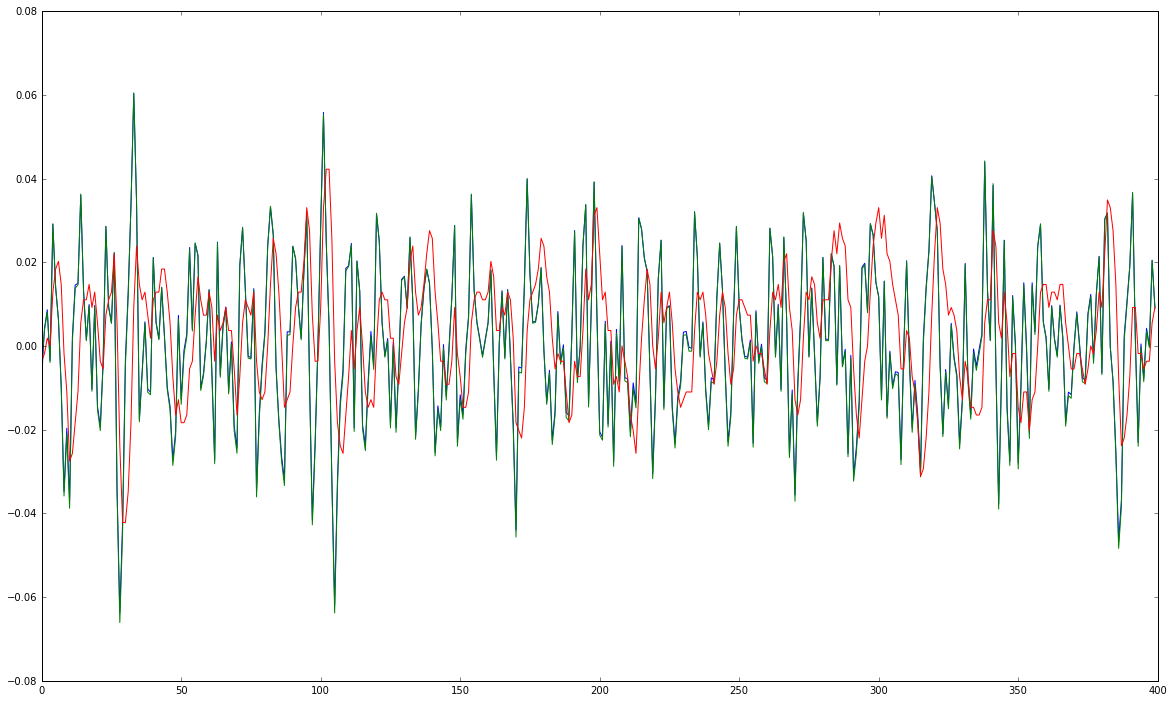

In [76]:
plt.figure(figsize=(20,12))

plt.plot(np.arange(400), y_pred[0].squeeze())
plt.plot(np.arange(400), Y_norm[1000000].squeeze())
plt.plot(np.arange(400), X_norm[1000000].squeeze())
plt.show()

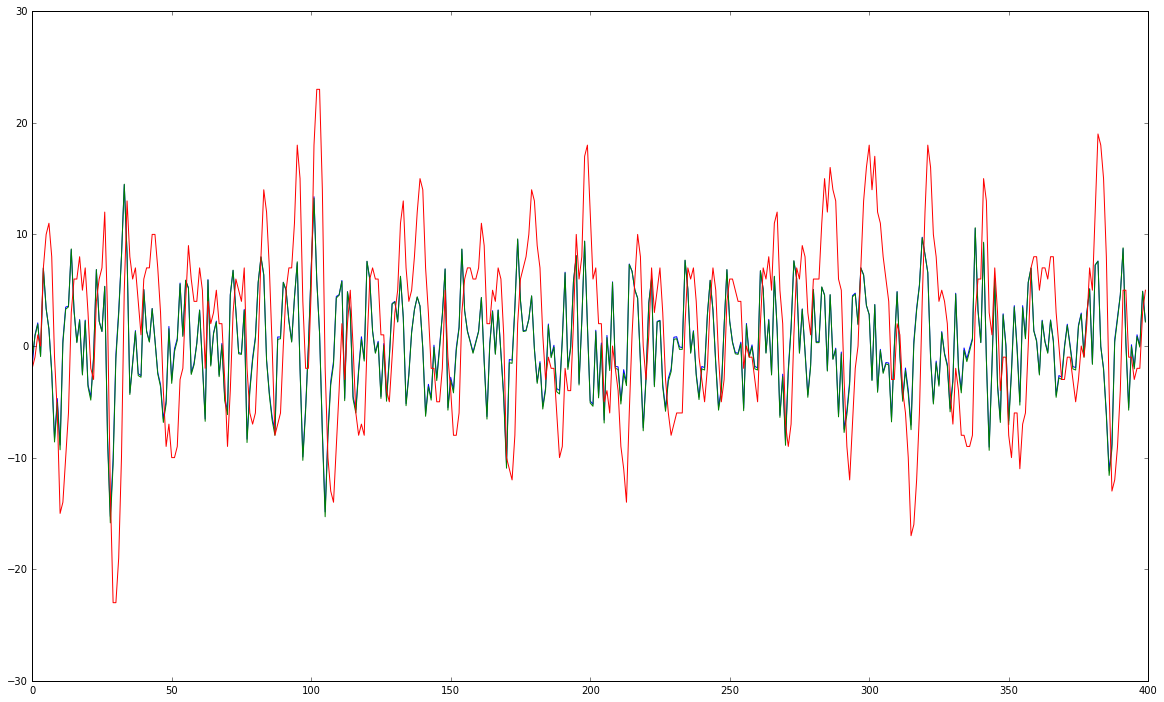

In [77]:
plt.figure(figsize=(20,12))

plt.plot(np.arange(400), y_pred[0].squeeze() * Y.std() + Y.mean())
plt.plot(np.arange(400), Y_norm[1000000].squeeze() * Y.std() + Y.mean())
plt.plot(np.arange(400), X_norm[1000000].squeeze() * X.std() + X.mean())
plt.show()

# Fourier Transform

In [106]:
fft_file = np.load('../fft_matrices_small.npz')
in_fft = fft_file['fft_in']
out_fft = fft_file['fft_out']

/home/timo/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


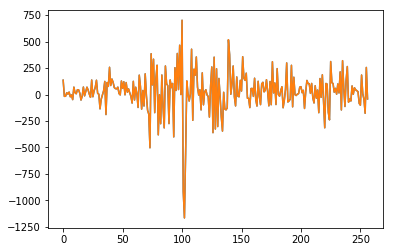

In [109]:
complex_spec = np.fft.rfft(in_fft,512)
plt.plot(complex_spec[0] * 3)
plt.plot(np.fft.rfft(in_fft*3,512)[0])
plt.show()

In [123]:
np.sum(powspec(in_fft, 512)[0]*9 - powspec(in_fft*3, 512)[0])

2.299826995511012e-13

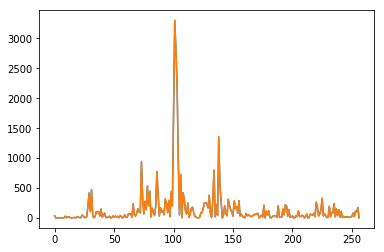

In [121]:
plt.plot(powspec(in_fft, 512)[0]*9)
plt.plot(powspec(in_fft*3, 512)[0])
plt.show()

In [126]:
in_fft

array([[  8.  ,  -2.6 ,   2.25, ...,   1.4 ,   1.45,  -3.5 ],
       [ -0.85,   3.1 ,   1.25, ...,  -1.9 ,  -3.  ,  -0.15],
       [ -7.8 ,   2.8 ,   6.95, ...,  -1.75,   2.15,   0.25],
       ...,
       [-36.65,  52.45, -32.9 , ...,   5.3 ,   7.7 ,  18.2 ],
       [ 47.1 ,  20.55, -11.45, ...,  15.3 ,  14.95,  -7.45],
       [ 30.15, -28.5 , -62.15, ...,   9.05,  21.9 ,   9.35]])

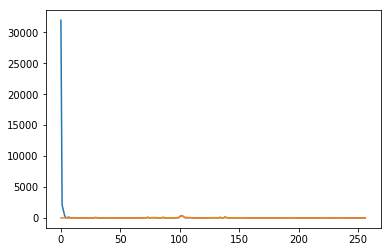

In [125]:
plt.plot(powspec(in_fft, 512)[0])
plt.plot(powspec(in_fft, 512)[0])
plt.show()

In [111]:
np.fft.rfft(in_fft,512) * 3 - np.fft.rfft(in_fft * 3,512)

array([[ 5.68434189e-14+0.00000000e+00j,  9.23705556e-14+1.42108547e-14j,
         5.68434189e-14-3.55271368e-15j, ...,
         0.00000000e+00+0.00000000e+00j,  8.52651283e-14+0.00000000e+00j,
        -7.10542736e-14+0.00000000e+00j],
       [-4.26325641e-14+0.00000000e+00j,  1.77635684e-14-2.13162821e-14j,
        -3.55271368e-14+1.42108547e-14j, ...,
         2.84217094e-14-2.84217094e-14j,  1.42108547e-14+0.00000000e+00j,
         1.42108547e-14+0.00000000e+00j],
       [-2.84217094e-14+0.00000000e+00j,  0.00000000e+00-3.55271368e-14j,
        -4.26325641e-14-3.55271368e-14j, ...,
        -5.68434189e-14+3.55271368e-14j, -5.68434189e-14+5.68434189e-14j,
         3.55271368e-15+0.00000000e+00j],
       ...,
       [-4.26325641e-13+0.00000000e+00j, -2.27373675e-13+2.27373675e-13j,
        -4.40536496e-13-7.10542736e-14j, ...,
        -1.13686838e-13+1.13686838e-13j,  4.54747351e-13+2.20268248e-13j,
         1.13686838e-13+0.00000000e+00j],
       [-3.41060513e-13+0.00000000e+00j, -8.

In [158]:
def fft_generator(frames, frames_normed):
    i = 0
    while True:
        if i >= len(frames):
            i = 0
        yield frames_normed[i], np.log(1 + powspec(np.expand_dims(frames[i].squeeze(), axis=0), 512))
        i += 1

In [124]:
def fft_generator_stop(frames):
    for frame in frames:
        yield powspec(np.expand_dims(frame.squeeze(), axis=0), 512)

In [128]:
X = None
X_norm = None

In [188]:
Y_fft_norm = np.expand_dims(np.log2(1+powspec(Y.squeeze(), 512)), axis=1)

In [317]:
Y_fft = powspec(Y.squeeze(), 512)

In [323]:
Y.squeeze().shape

(1128519, 400)

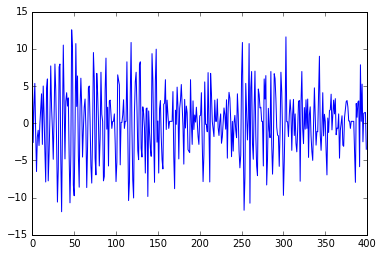

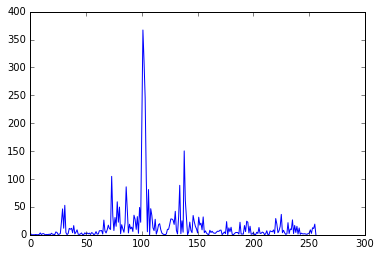

In [325]:
plt.plot(Y.squeeze()[0])
plt.show()
plt.plot(Y_fft[0])
plt.show()

In [321]:
np.savez('fft_matrices_small', fft_in=Y.squeeze()[:1000], fft_out=Y_fft[:1000])

In [166]:
Y_fft_norm.shape

(1128519, 1, 257)

In [135]:
fft_mean = np.mean(powspec(Y.squeeze(), 512))
fft_std = np.std(powspec(Y.squeeze(), 512))

In [138]:
fft_std

644141.98309723509

In [141]:
np.max((powspec(Y.squeeze(), 512))

KeyboardInterrupt: 

In [145]:
fft_mean

44796.92682141668

In [157]:
np.log(991764015 + 1)

20.714995748844444

In [143]:
(991764015 - fft_mean) / fft_std

1539.5972380261319

In [ ]:
#def sine_activation()

In [196]:
def fft_model():
    model = Sequential()
    model.add(Dense(1024, activation='relu', input_dim=400))
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(257, activation='relu'))
    
    model.summary()
    sgd = SGD(lr=0.01)
    model.compile(loss='mean_squared_error', optimizer=sgd, metrics=[metrics.mae, metrics.mse])
    return model

In [198]:
model_fft = fft_model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 1024)              410624    
_________________________________________________________________
dense_10 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dense_11 (Dense)             (None, 257)               263425    
Total params: 1,723,649
Trainable params: 1,723,649
Non-trainable params: 0
_________________________________________________________________


In [120]:
powspec(Y[60:62].squeeze(), 512)

array([[  2.56730908e+01,   1.84854965e+01,   1.52346542e+01,
          8.02490382e+00,   4.57931809e+01,   3.60681202e+02,
          2.36554615e+03,   1.18650247e+04,   1.33142501e+02,
          7.53516403e+02,   7.52031754e+02,   5.97327301e+02,
          1.61403097e+02,   1.37681423e+04,   1.41242499e+04,
          1.46581313e+02,   8.62782334e+02,   1.76570521e+03,
          4.83945736e+03,   2.37429742e+03,   7.29416688e+04,
          2.61980702e+04,   5.54488102e+03,   9.31183234e+00,
          6.81285938e+02,   9.44737040e+03,   2.07102715e+04,
          2.18173198e+05,   1.69185682e+04,   2.33677704e+04,
          2.73732547e+03,   1.67145123e+02,   1.04523480e+04,
          3.00969278e+04,   6.05645078e+04,   3.05731657e+03,
          5.97717802e+03,   3.12838943e+02,   2.59719694e+02,
          1.85523057e+03,   8.56513013e+03,   4.69651431e+03,
          4.00666737e+02,   9.02505478e+01,   7.40565957e+00,
          4.78343530e+01,   1.95908920e+02,   2.75786846e+03,
        

In [153]:
np.sqrt(0)

0.0

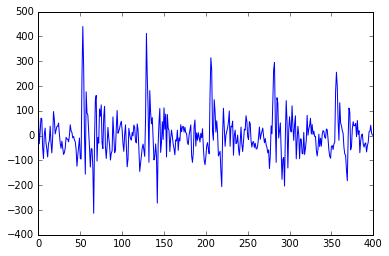

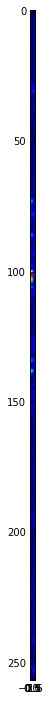

In [121]:
plt.plot(Y[60].squeeze())
plt.show()
plt.figure(figsize=(20,12))
plt.imshow(powspec(Y[0:100].squeeze(), 512).transpose())
plt.show()

In [199]:
model_fft.fit(Y_norm.squeeze(), Y_fft_norm.squeeze())

Epoch 1/10
1128519/1128519 [==============================] - 1182s - loss: 9.5148 - mean_absolute_error: 2.2229 - mean_squared_error: 9.5148  
Epoch 2/10
 296928/1128519 [======>.......................] - ETA: 854s - loss: 6.9566 - mean_absolute_error: 1.8738 - mean_squared_error: 6.9566

KeyboardInterrupt: 

In [201]:
y_fft_pred = model_fft.predict(Y_norm[0:100].squeeze())

In [214]:
y_fft_pred.shape

(100, 257)

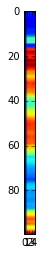

In [211]:
plt.imshow(y_fft_pred[:, 105:110])
plt.show()

In [212]:
y_fft_pred[:, 105]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.], dtype=float32)

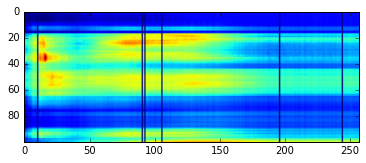

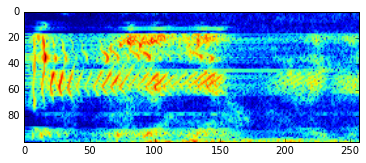

In [203]:
plt.imshow(y_fft_pred)
plt.show()
plt.imshow(Y_fft_norm[0:100].squeeze())
plt.show()

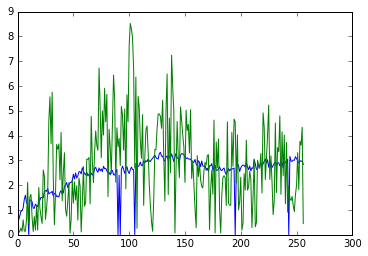

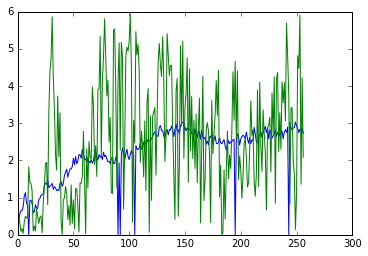

In [216]:
plt.plot(y_fft_pred[0])
plt.plot(Y_fft_norm[0,0])
plt.show()
plt.plot(y_fft_pred[1])
plt.plot(Y_fft_norm[1,0])
plt.show()

In [219]:
fft_input = Y[0, :, 0]

In [237]:
fft_input.shape

(400,)

In [235]:
fft_output = powspec(Y[:2].squeeze(), 512)[0]

In [236]:
fft_output.shape

(257,)

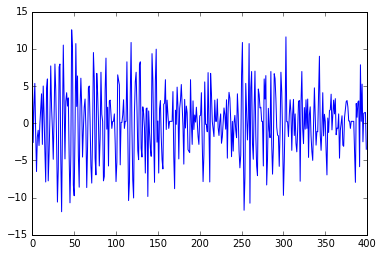

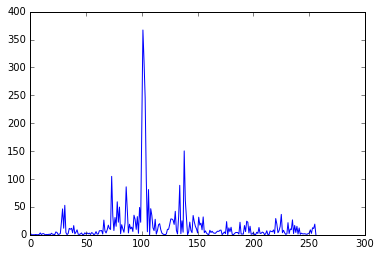

In [238]:
plt.plot(fft_input)
plt.show()
plt.plot(fft_output)
plt.show()

In [263]:
a = np.array([1+2j, 3+4j, 5+6j])

In [268]:
(1-1j)**2

-2j

In [270]:
np.pi

3.141592653589793

In [326]:
N = 512
K = 512

out = []
for k in range(0,K+1):
    x_out = 0
    for n in range(0, N):
        w = float(np.exp(-1j*k*n*((2*np.pi)/N)))
        if n < len(fft_input):
            x_n = fft_input[n] * w
        else:
            x_n = 0 * w
        x_out += x_n
    out.append(x_out)

/home/tvniedek/.local/lib/python2.7/site-packages/ipykernel_launcher.py:8: ComplexWarning: Casting complex values to real discards the imaginary part
  


In [329]:
out

[45.10000000000003,
 -5.7394765966755834,
 -5.4620619849611778,
 5.7820183613426108,
 1.2553673021739349,
 7.7195293783000434,
 -7.0880030959156883,
 -1.3037402771023299,
 -16.018286168802476,
 23.264377304907104,
 5.5831665865620925,
 2.4170934902747629,
 15.186932401251607,
 14.700276372463684,
 4.0054790061049683,
 -17.347167942946264,
 -5.3992463808735458,
 23.538395915131655,
 -4.1779201304510032,
 8.907100027475428,
 23.135257351685084,
 14.28276382643593,
 0.97383773998581225,
 -8.7366171845417888,
 45.671506090382806,
 -7.0099170554634824,
 11.175227525942931,
 22.926544857014427,
 44.977300928581656,
 3.5673546832950733,
 1.189240432631899,
 -45.073533003029674,
 -14.732721878863101,
 -1.0386075023005497,
 11.413427323827108,
 41.247156363398275,
 -63.029288957930859,
 37.803315534378768,
 25.581082658873335,
 85.82007173614636,
 28.439713973598614,
 48.745213841277192,
 38.576017878286429,
 21.885966004184034,
 18.623468389999491,
 17.990678369845405,
 23.175860109585926,
 2.

In [105]:
complex_spec = np.fft.rfft(fft_input,512)

NameError: name 'fft_input' is not defined

In [300]:
complex_spec

array([  4.51000000e+01 +0.00000000e+00j,
        -5.73947660e+00 -1.19572616e-01j,
        -5.46206198e+00 -4.80106414e+00j,
         5.78201836e+00 -8.58577622e+00j,
         1.25536730e+00 -7.08025405e+00j,
         7.71952938e+00 +1.43297281e+01j,
        -7.08800310e+00 -2.26348798e+00j,
        -1.30374028e+00 -7.24616615e+00j,
        -1.60182862e+01 +4.16322380e+00j,
         2.32643773e+01 +3.41744904e+01j,
         5.58316659e+00 -1.22417741e+01j,
         2.41709349e+00 +3.09408330e+01j,
         1.51869324e+01 -2.90002356e+01j,
         1.47002764e+01 +1.03553135e+01j,
         4.00547901e+00 -5.80205758e+00j,
        -1.73471679e+01 +6.38565443e+00j,
        -5.39924638e+00 +6.66660431e+00j,
         2.35383959e+01 +8.32460299e+00j,
        -4.17792013e+00 +7.29413423e+00j,
         8.90710003e+00 +3.64602729e+01j,
         2.31352574e+01 -5.36842151e+00j,
         1.42827638e+01 -1.15459296e+01j,
         9.73837740e-01 -1.37726765e+01j,
        -8.73661718e+00 +5.0421467

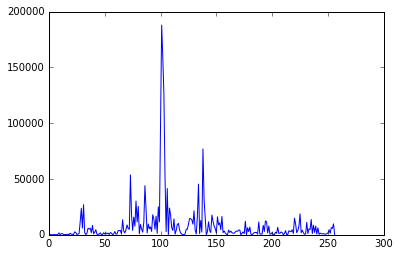

In [294]:
plt.plot(np.square(np.abs(complex_spec)))
plt.show()

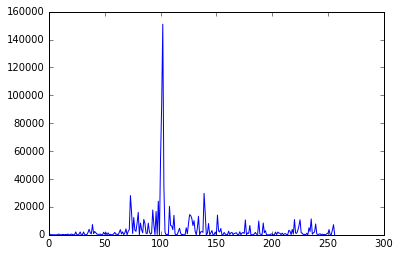

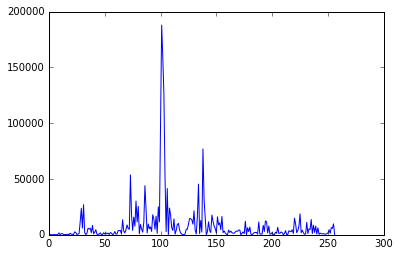

In [315]:
plt.plot(np.square(np.abs(out))[:257])
plt.show()
plt.plot(fft_output * 512)
plt.show()

# Fourier Tranform (actually implemented)

In [31]:
from keras import backend as K
from keras.engine.topology import Layer

class FftLayer(Layer):
    def __init__(self, NFFT=512, **kwargs):
        self._NFFT = NFFT
        super(FftLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        np_we =  np.zeros((self._NFFT, input_shape[1], 2))
        for k in range(0, self._NFFT):
            for n in range(0, input_shape[1]):
                w = np.exp(-1j*k*n*((2*np.pi)/self._NFFT))
                np_we[k, n, 0]  = w.real
                np_we[k, n, 1] = w.imag
        self.we = K.variable(np_we.transpose(2,1,0))
        self._trainable_weights.append(self.we)
        super(FftLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, x):
        sum_real = K.dot(x, self.we[0])
        sum_imag = K.dot(x, self.we[1])
        aggregated = K.stack([sum_real, sum_imag], axis=1)        
        out_agg = K.sum(K.square(aggregated), axis=1)
        return out_agg[:,:257] * (1.0 / self._NFFT)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], 257)


In [5]:
fft_model = Sequential([
    FftLayer(input_shape=(400,), trainable=False)
])
fft_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
fft_layer_1 (FftLayer)       (None, 257)               409600    
Total params: 409,600
Trainable params: 0
Non-trainable params: 409,600
_________________________________________________________________


# From power spectrum to filterbanks

In [2]:
with np.load('../fft_matrices_small.npz') as matrices_small:
    fft_out = matrices_small['fft_out']

In [5]:
fft_out.shape

(1128519, 257)

In [6]:
log_fft_out = np.log(np.where(fft_out == 0,np.finfo(float).eps,fft_out))

In [128]:
fft_out_norm = fft_out / np.std(fft_out)

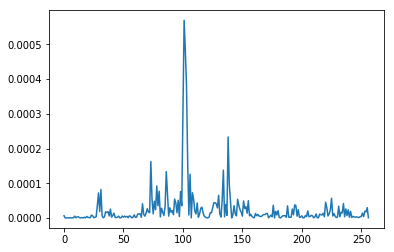

In [129]:
plt.plot(fft_out_norm[0])
plt.show()

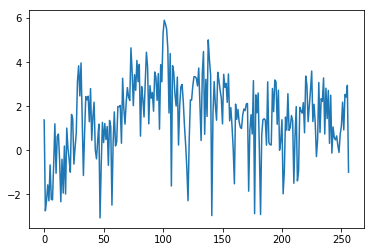

In [23]:
plt.plot(np.log(fft_out[0]))
plt.show()

In [11]:
log_fft_mean = np.mean(log_fft_out)
log_fft_std = np.std(log_fft_out)
fft_norm = (log_fft_out - log_fft_mean)/log_fft_std

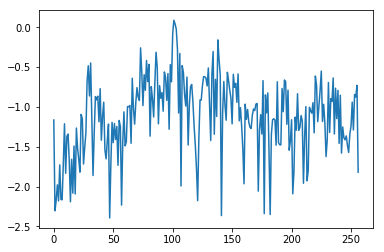

In [9]:
plt.plot(fft_norm[0])
plt.show()

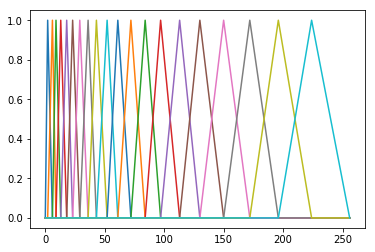

In [10]:
fbanks = get_filterbanks(20, 512, 16000, 0, None)
for fbank in fbanks:
    plt.plot(fbank)
plt.show()

In [14]:
filterbanks_out = np.dot(fft_out, fbanks.T)
filterbanks_out = np.log(np.where(filterbanks_out == 0,np.finfo(float).eps,filterbanks_out))

In [15]:
fbanks_mean = np.mean(filterbanks_out)
fbanks_std = np.mean(filterbanks_out)

In [16]:
filterbanks_norm = (filterbanks_out - fbanks_mean) / fbanks_std

In [17]:
fft_out.shape

(1128519, 257)

In [18]:
filterbanks_out.shape

(1128519, 20)

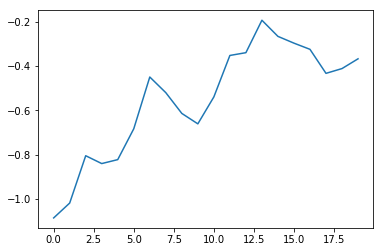

In [122]:
plt.plot((filterbanks_out[0] - fbanks_mean) / fbanks_std)
plt.show()

In [19]:
def filterbank_model():
    model = Sequential()
    model.add(Dense(512, activation='linear', input_dim=257))
    model.add(Dense(512, activation='linear'))
    model.add(Dense(20, activation='linear'))
    
    model.summary()
    sgd = SGD(lr= 0.001)
    model.compile(loss='mean_squared_error', optimizer=sgd, metrics=[metrics.mae, metrics.mse])
    return model

In [20]:
model_fbank = filterbank_model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               132096    
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_3 (Dense)              (None, 20)                10260     
Total params: 405,012
Trainable params: 405,012
Non-trainable params: 0
_________________________________________________________________


In [21]:
model_fbank.fit(fft_norm, filterbanks_norm)

Epoch 1/1
1128519/1128519 [==============================] - 105s 93us/step - loss: 0.0326 - mean_absolute_error: 0.1246 - mean_squared_error: 0.0326


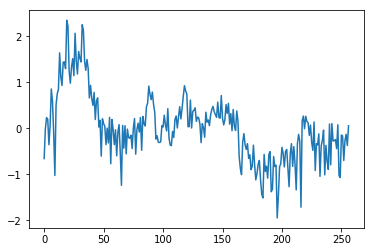

In [156]:
plt.plot(fft_norm[200])
plt.show()

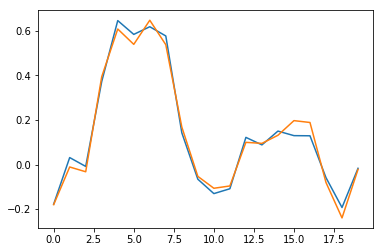

In [155]:
i = 200
fbank_out_pred = model_fbank.predict(np.expand_dims(fft_norm[i],axis=0))
plt.plot(filterbanks_norm[i])
plt.plot(fbank_out_pred[0])
plt.show()

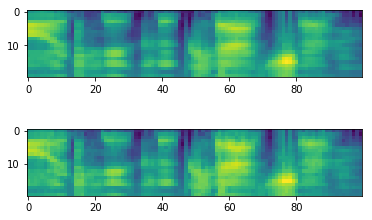

In [165]:
i = 200
fbank_out_pred = model_fbank.predict(fft_norm[i:i+100])
plt.subplot(211)
plt.imshow(filterbanks_out[i:i+100].T)
plt.subplot(212)
plt.imshow(fbank_out_pred.T)
plt.show()

In [144]:
fbank_out_pred.shape

(1, 20)

# Discrete Cosine Transform

In [28]:
from scipy.fftpack import dct
from keras.layers.core import Lambda

In [26]:
numcep = 13

In [86]:
class DCTLayer(Layer):
    def __init__(self, numcep=13, norm=None, **kwargs):
        self._numcep = numcep
        self._norm = norm
        super(DCTLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self._N = input_shape[1]
        np_we =  np.zeros((self._N, self._N))
        for k in range(0, self._N):
            for n in range(0, self._N):
                w = np.cos((np.pi / self._N) * (n+0.5) * k)
                np_we[n, k] = w
        self.we = K.variable(np_we)
        self._trainable_weights.append(self.we)
        super(DCTLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, x):
        print(K.int_shape(x))
        print(K.int_shape(self.we))
        dct_out = 2 * K.dot(x, self.we)
        dct_out = dct_out[:,:self._numcep]
        print(K.int_shape(x))
        if self._norm == 'ortho':
            norm_0 = K.expand_dims(dct_out[:, 0] * K.sqrt(K.constant(1 / (4 * self._N))), axis=1)
            norm_ = dct_out[:, 1:] * K.sqrt(K.constant(1 / (2 * self._N)))
            dct_out = K.concatenate([norm_0, norm_], axis=1)
        return dct_out

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self._numcep)

In [87]:
model = Sequential([
    DCTLayer(numcep=13, norm='ortho', input_shape=(20,), trainable=False)
])
model.summary()

(None, 20)
(20, 20)
(None, 20)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dct_layer_18 (DCTLayer)      (None, 13)                400       
Total params: 400
Trainable params: 0
Non-trainable params: 400
_________________________________________________________________


In [88]:
x = np.expand_dims(filterbanks_out[0], axis=0)
y = model.predict(x)

In [72]:
y - dct(x, type=2, axis=1)[0,:numcep]

array([[-1.16336288e-05,  7.33891376e-07,  4.90625148e-07,
         5.85410517e-07,  1.82730503e-06, -1.48037850e-06,
        -6.39018333e-07,  4.27239857e-07, -1.92125575e-07,
         2.68974377e-07,  3.21226312e-07, -1.55772026e-06,
         1.08253741e-06]])

In [104]:
dct(3*(x-4), type=2, axis=1, norm='ortho')[0,:numcep]-3*(dct(x, type=2, axis=1, norm='ortho')[0,:numcep])

array([-5.36656315e+01,  7.10542736e-15,  0.00000000e+00, -1.66533454e-16,
        1.77635684e-15,  4.44089210e-16, -1.77635684e-15,  4.44089210e-16,
        8.88178420e-16, -2.66453526e-15,  1.66533454e-15, -1.99840144e-15,
        1.33226763e-15])

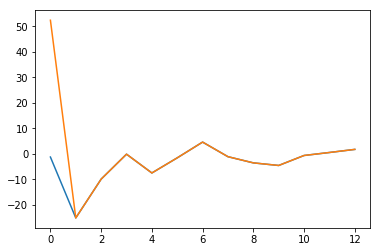

In [102]:
plt.plot(dct(3*(x-4), type=2, axis=1, norm='ortho')[0,:numcep])
plt.plot(3*(dct(x, type=2, axis=1, norm='ortho')[0,:numcep]))
plt.show()

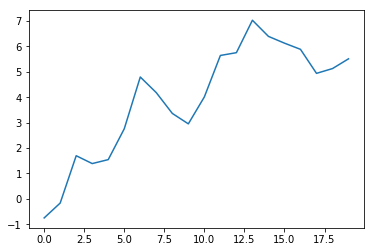

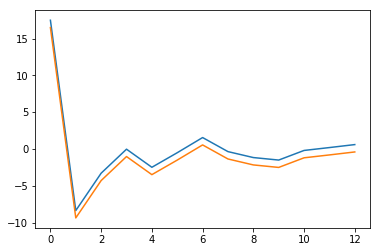

In [95]:
plt.plot(x[0])
plt.show()
plt.plot(y[0])
plt.plot(dct(x, type=2, axis=1, norm='ortho')[0,:numcep] - 1)
plt.show()

In [29]:
filterbanks_out.shape

(1128519, 20)

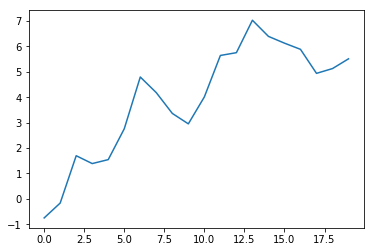

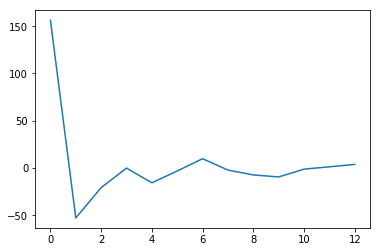

In [44]:
plt.plot(filterbanks_out[0])
plt.show()
plt.plot(dct(filterbanks_out[:2], type=2, axis=1)[0,:numcep])
plt.show()

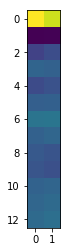

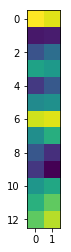

In [186]:
after_dct = dct(filterbanks_out[:2], type=2, axis=1, norm='ortho')[:,:numcep]
plt.imshow(after_dct.T)
plt.show()
plt.imshow(lifter(after_dct, 22).T)
plt.show()

In [190]:
filterbanks_out.shape

(1128519, 20)

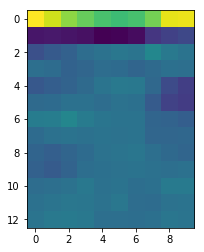

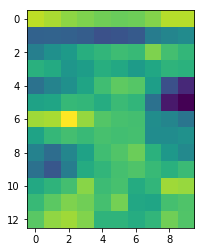

In [187]:
after_dct = dct(filterbanks_out[:10], type=2, axis=1, norm='ortho')[:,:numcep]
plt.imshow(after_dct.T)
plt.show()
plt.imshow(lifter(after_dct, 22).T)
plt.show()

In [188]:
energy = np.sum(fft_out,1)
energy = np.where(energy == 0,np.finfo(float).eps,energy)

In [189]:
lifter_out = dct(filterbanks_out, type=2, axis=1, norm='ortho')[:,:numcep]
lifter_out = lifter(lifter_out, 22)
lifter_out[:,0] = np.log(energy)

In [191]:
lifter_out.shape

(1128519, 13)

In [192]:
def mfcc_network():
    model = Sequential()
    model.add(Dense(512, activation='linear', input_dim=20))
    model.add(Dense(512, activation='linear'))
    model.add(Dense(13, activation='linear'))
    
    model.summary()
    sgd = SGD(lr=0.001)
    model.compile(loss='mean_squared_error', optimizer=sgd, metrics=[metrics.mae, metrics.mse])
    return model

In [193]:
model_mfcc = mfcc_network()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_55 (Dense)             (None, 512)               10752     
_________________________________________________________________
dense_56 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_57 (Dense)             (None, 13)                6669      
Total params: 280,077
Trainable params: 280,077
Non-trainable params: 0
_________________________________________________________________


In [212]:
model_mfcc.fit(filterbanks_out, lifter_out)

Epoch 1/1
1128519/1128519 [==============================] - 113s 100us/step - loss: 0.0373 - mean_absolute_error: 0.0581 - mean_squared_error: 0.0373


In [213]:
mfcc_pred = model_mfcc.predict(filterbanks_out[:100])

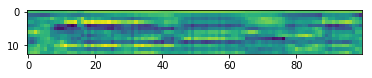

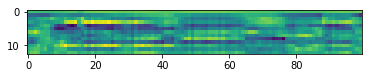

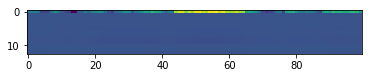

In [214]:
plt.imshow(mfcc_pred.T)
plt.show()
plt.imshow(lifter_out[:100].T)
plt.show()
plt.imshow(mfcc_pred.T - lifter_out[:100].T)
plt.show()

In [218]:
(mfcc_pred - lifter_out[:100])[:,0]

array([ 0.4202227 ,  0.4156644 ,  0.47843544,  0.30844602, -0.16741659,
       -0.18649777, -0.09241242,  0.35296289,  0.64670616,  0.33518255,
        0.06068241, -0.0617355 , -0.25101689, -0.70315565, -0.64224825,
        0.03172716,  0.14277376,  0.38366765,  0.19900946,  0.45027379,
        0.49942093,  0.65746692,  0.54838818,  0.27971258,  0.00961847,
       -0.18765332,  0.20706182,  0.31391874,  0.54319515,  0.66562074,
        0.54800704,  0.08632813,  0.40929675,  0.5493975 ,  0.66636328,
        0.85253778,  0.76555598,  1.07846558,  0.93668918,  0.89311575,
        0.49926144,  0.25591546,  0.48281704,  0.38996618,  1.62573224,
        1.83824078,  1.83864699,  1.53688973,  1.79743704,  1.60101212,
        1.87258297,  1.93873811,  1.78191862,  1.69673249,  1.97567525,
        1.94811267,  2.00208845,  1.7675959 ,  1.9181191 ,  1.67424375,
        1.63018659,  1.63553412,  1.76660917,  1.59691528,  1.59977727,
        0.8498314 ,  0.93455477,  0.79407485,  0.64557444,  0.27

In [199]:
mfcc_pred[0]

array([  8.796899  , -21.47024   , -13.504159  ,  -0.16389468,
       -17.291777  ,  -4.1695266 ,  14.447224  ,  -3.6613915 ,
       -12.811885  , -17.380854  ,  -2.376858  ,   2.2974424 ,
         7.077721  ], dtype=float32)

In [200]:
lifter_out

array([[  8.32681805, -21.45799342, -13.48911807, ...,  -2.38171301,
          2.28941199,   7.07418369],
       [  7.81077889, -20.98729372,  -9.0724696 , ...,   0.86803296,
          7.32139152,  13.00904123],
       [  7.37041386, -21.58428471,  -6.22256633, ...,   4.25179115,
         11.18760223,  14.3953492 ],
       ...,
       [  7.15094685, -15.56747581, -10.79042868, ...,   2.31189216,
         -4.77495947,  -5.50538401],
       [  7.22540825, -13.62523092,  -9.35942759, ...,  -3.49607605,
         -9.80649924,  -5.46862631],
       [  7.15872824, -14.47385076, -10.60221693, ...,  -5.95743058,
         -3.94964456,  -5.54881807]])